# Integral Windup and Bumpless Transfer

> "the devil is in the details" -- anonymous

> "and everything is detail" -- military expression

> "why me?" -- the devil

![](https://cdn.instrumentationtools.com/wp-content/uploads/2020/01/Identify-Process-Variables-in-PID.png)

## Learning Goals

Up to this point we have been giving a "textbook" introduction to proportional-integral (PI) control. There is a world of difference between "textbook" and "practical". 

* Explain the purpose of each of the following enhancements of 'textbook' PI control:
    * Anti-reset windup
         * What is reset windup?
         * Fix 1: Insert limits on the manipulated variable (MV)
         * Fix 2: If possible, get field measurements of the manipulated variable (MV)
    * Bumpless Transfer
         * What is bumpless transfer?
         * Manual to Auto transition

## PI Control

Proportional-Integral (PI) Control is velecity form

\begin{align}
MV_k & = MV_{k-1} - K_P (e_{k} - e_{k-1}) - \delta t K_I e_k
\end{align}

where $MV_0= \bar{MV}$ is the initial value, and the error $e_k$ is the difference between the process variable and setpoint

\begin{align}
e_k & = PV_k - SP_k \\
\end{align}

and $\delta t$ is the time step.

We encode the controller using the Python `yield' statement. The implementation has added `t_step` to facilitate use of this code for situations where we may change the time step or have a variable time step.

In [1]:
# caution: this is not a final version of our PI controller

def PI(Kp, Ki, MV_bar=0):
    MV = MV_bar
    e_prev = 0
    while True:
        t_step, SP, PV = yield MV
        e = PV - SP
        MV = MV - Kp*(e - e_prev) - t_step*Ki*e
        e_prev = e

The benefits of using the `yield` statement is that we can use the same code to create multiple instances of controller, each with it's own parameters and state. The communication between the main event loop and a controller instance is illustrated in this diagram:

![](https://jckantor.github.io/cbe30338-2021/figures/controller-coroutine.png)

The following cells demonstrate performance of the controller when subject to a step change in setpoint and a disturbance input.

In [11]:
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment(controller, t_step=5, t_final=1000,
               SP=lambda t: 40 if t >= 20 else 0, 
               DV=lambda t: 100 if t >= 420 else 0):

    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:
        sources = (("T1", lambda: lab.T1), ("SP", lambda: SP(t)), 
                   ("U1", lambda: U1), ("Q1", lab.Q1))
        h = Historian(sources)
        p = Plotter(h, t_final, layout=[("T1", "SP"), ("Q1", "U1")])

        # initialize manipulated variable
        lab.P1 = 200
        lab.P2 = 200
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = controller.send((t_step, SP(t), T1))
            lab.Q1(U1)
            lab.Q2(DV(t))                        # <= disturbance
            p.update(t)

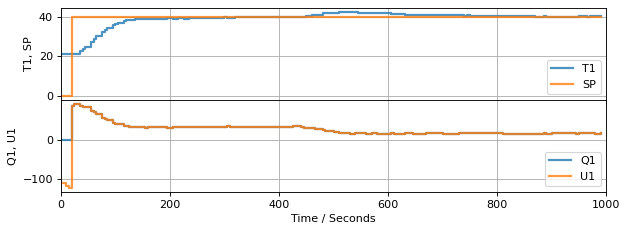

TCLab Model disconnected successfully.


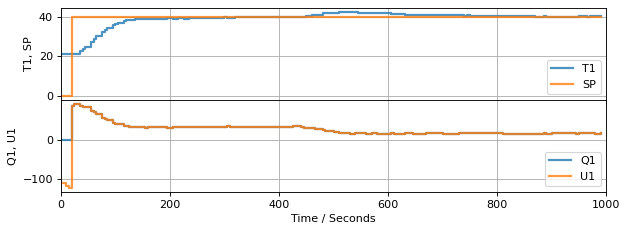

In [12]:
experiment(PI(5, 0.05))

## What is Integral Windup?

Let's increase the magnitude of the control gains to see if we an acheive even better control performance.

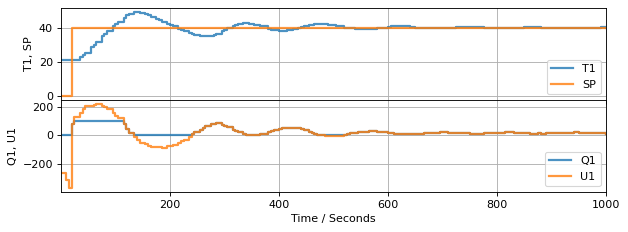

TCLab Model disconnected successfully.


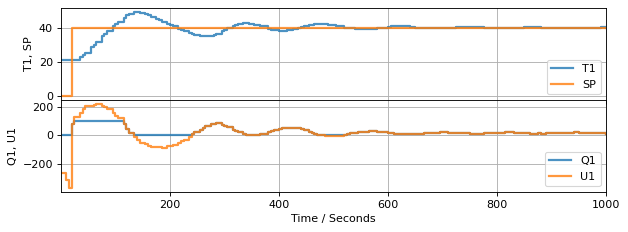

In [13]:
experiment(PI(10, 0.5))

<hr>

**Study Question:** Carefully exammine the results of this experiment. The PI velocity algorithm is given by an equation

\begin{align}
MV_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - h K_i e_{k}
\end{align}

Looking at the period from 0 to 100 seconds, is this equation being satisfied? Why or why not?  

**Study Question:** Carefully examine the code for the PI controller. How is it possible for $MV$ to be different from the actual input applied to the device?

<hr>

**Integral (aka Reset) windup is a consequence the controller computing values for the manipulable input that are outside the range of feasible values. The difference is due to the presence of upper and lower bounds on the manipulated variable.**

### Anti-reset windup - Version 1

There several common strategies for avoiding integral (aka reset) windup. The first of these, which should be part of any practical implementation, is to limit computed values of manipulated variable to the range of values that can be implemented in the actual process. This will avoid $MV$ 'winding up' due to range limits.

\begin{align}
\hat{MV}_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - \delta t K_i e_{k} 
\end{align}

\begin{align}
MV_k & = \begin{cases}
MV^{min} & \text{if } \hat{MV}_k \leq MV^{min}\\
\hat{MV}_k & \text{if } MV^{min} \leq \hat{MV}_k \leq MV^{max}\\
MV^{max} & \text{if}  \hat{MV_k} \geq MV^{max}
\end{cases}
\end{align}

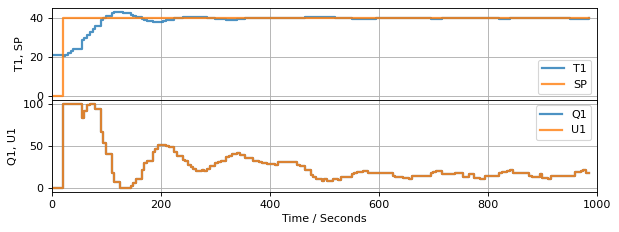

TCLab Model disconnected successfully.


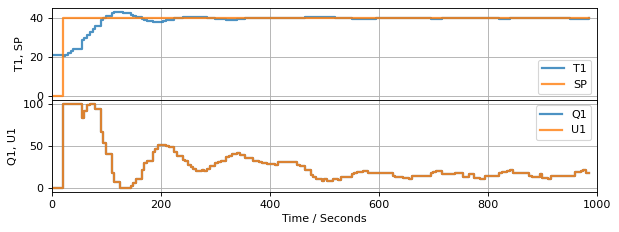

In [14]:
# add anti-integral windup feature. Not yet final.

def PI_antiwindup_1(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        t_step, SP, PV = yield MV
        e = PV - SP
        MV = MV - Kp*(e - e_prev) - t_step*Ki*e
        MV = max(MV_min, min(MV_max, MV))
        e_prev = e

experiment(PI_antiwindup_1(10, 0.5))

### Anti-reset Windup - Version 2

A more subtle form of windup occurs when the manipulated variable is subject to external interventions. This can occur when a valve stem in a process application gets stuck, an operator or user intervenes and resets a mechanical actuator, or there is some sort of system failure. 

For these reasons, practical control systems often include a field measurement of the manipulated variable that is fed back to the controller. The following image, for example, shows a pneumatically operated globe valve with a positioner, and with feedback of position to the central control system.

<p><a href="https://commons.wikimedia.org/wiki/File:Pl_control_valve.jpg#/media/File:Pl_control_valve.jpg"><img src="https://upload.wikimedia.org/wikipedia/commons/b/b2/Pl_control_valve.jpg" alt="Pl control valve.jpg" height="720" width="540"></a>
    
 <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>
    
Stepper motors are commonly used actuators in lab equipment and robotics. The position of the stepper motor would be manipulated variable. This is an example of a stepper motor with an integrated encoder that can be used to verify the motor's position.
    
![](https://www.portescap.com/-/media/project/automation-specialty/portescap/portescap/products/workings-of-encoders/encoder_chart_720x450_1_0.jpg)

Valve position feedback is a feature of control valves used in process applications, and should be regarded as a 'best practice' for industrial automation.

![](https://jckantor.github.io/cbe30338-2021/figures/valve-position-feedback.png)

This behavior also occurs in the Temperature Control Laboratory in which the manipulated power levels are constrained to the range 0% to 100%. This is demonstated in the following cell.

In [15]:
# show that inputs to the TCLab are constrained to the range 0 to 100%

TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    print(f"Q1 = {lab.Q1()}")
    lab.Q1(150)
    print(f"Q1 = {lab.Q1()}")

TCLab version 0.4.9
Simulated TCLab
Q1 = 0
Q1 = 100
TCLab Model disconnected successfully.


To accomodate feedback of the manipulated variable, we first need to modify the event loop to incorporate the measurement of the manipulated variable, then send that value to the controller.

In [16]:
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment_2(controller, t_final=1000, t_step=5,
               SP=lambda t: 40 if t >= 20 else 0, 
               DV=lambda t: 100 if t >= 420 else 0):
    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:

        # set up historian and plotter
        sources = (("T1", lambda: lab.T1), ("SP", lambda: SP(t)), 
                   ("U1", lambda: U1), ("Q1", lab.Q1))
        h = Historian(sources)
        p = Plotter(h, t_final, layout=[("T1", "SP"), ("Q1", "U1")])

        # initialize manipulated variable
        lab.P1 = 200
        next(controller)

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = lab.Q1()                            # <==== new line
            U1 = controller.send((t_step, SP(t), T1, U1))    # <==== send U1 to controller 
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t)     

The next change is to the controller. The controller now accepts values for PV, SP, and, additionally, MV. To demonstrate the impact of these changes, this example will comment out the software limits placed on MV to show that feedback of manipulated variable is also an anti-reset windwup strategy.

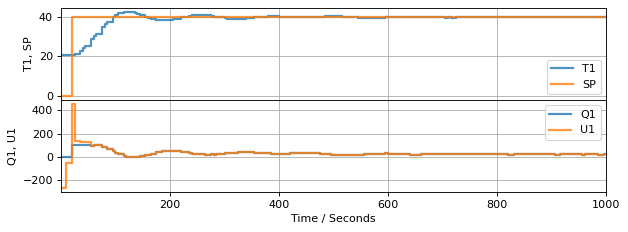

TCLab Model disconnected successfully.


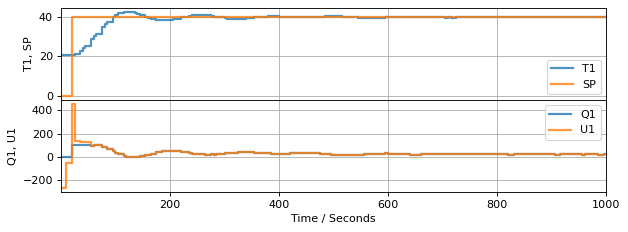

In [17]:
# add anti-integral windup feature. Not yet final.

def PI_antiwindup_2(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        t_step, SP, PV, MV = yield MV   # <==== now gets MV from experiment
        e = PV - SP
        MV = MV - Kp*(e - e_prev) - t_step*Ki*e 
        # MV = max(MV_min, min(MV_max, MV)) # <=== turn this off for demo
        e_prev = e

experiment_2(PI_antiwindup_2(10, 0.5))

### Anti-reset Windup - Complete

With these considerations in place, the following cell presents a version of the PI control algorithm incorporating both range limits and direct feedback of the manipulated variables.

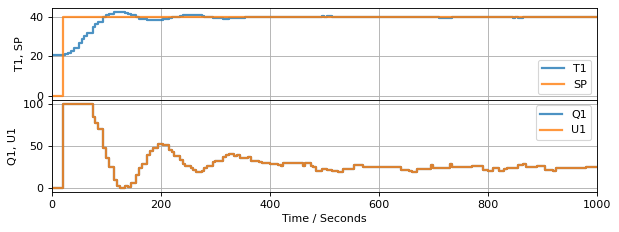

TCLab Model disconnected successfully.


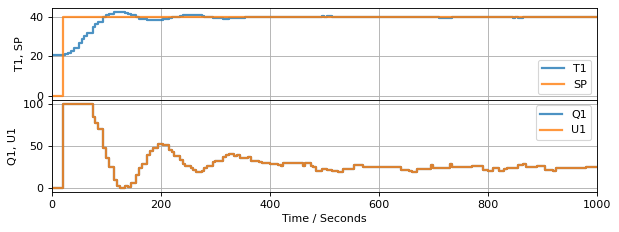

In [18]:
# add anti-integral windup feature.

def PI_antiwindup(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        t_step, SP, PV, MV = yield MV       # <= now gets MV from experiment
        e = PV - SP
        MV = MV - Kp*(e - e_prev) - t_step*Ki*e 
        MV = max(MV_min, min(MV_max, MV))   # <= range limits
        e_prev = e
        
experiment_2(PI_antiwindup(10, 0.5))

## Manual to Auto Transition: Bumpless Transfer

Manual operation can be implemented by specifying the manipulated variable. We will implement this by specifying a function that specifies values of manipulated variable whenever manual conteol is in effect. 

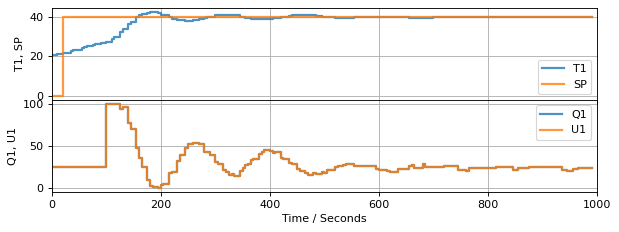

TCLab Model disconnected successfully.


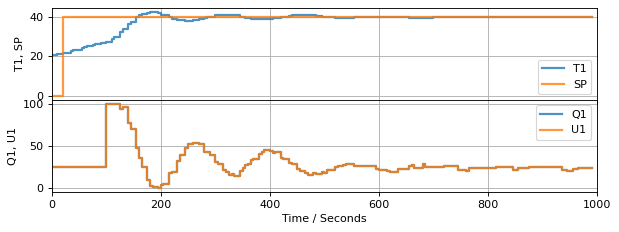

In [19]:
from tclab import TCLab, clock, Historian, Plotter, setup

def experiment_3(controller, t_final=1000, t_step=5,
               SP=lambda t: 40 if t >= 20 else 0, 
               DV=lambda t: 100 if t >= 420 else 0,
               MV=lambda t: 25 if t <= 100 else None):   # <== manipulated variable. Return none for auto
    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:

        # set up historian and plotter
        sources = (("T1", lambda: lab.T1), ("SP", lambda: SP(t)), 
                   ("U1", lambda: U1), ("Q1", lab.Q1))
        h = Historian(sources)
        p = Plotter(h, t_final, layout=[("T1", "SP"), ("Q1", "U1")])

        # initialize manipulated variable
        lab.P1 = 200
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = lab.Q1()
            if MV(t) is None:           
                U1 = controller.send((t_step, SP(t), T1, U1))    # automatic control
            else:
                U1 = MV(t)                                       # manual control
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t)  
            
experiment_3(PI_antiwindup(10, 0.5))

## Bumpless Transfer

* Remove setpoint from proportional term
* Only the integral control term incorporates the setpoint. 

### Bumpless Transfer

\begin{align}
e_k & = PV_k - SP_k \\
\hat{MV}_{k} & = MV_{k-1} - K_p(PV_{k} - PV_{k-1}) - \delta t K_i e_{k} 
\end{align}

\begin{align}
MV_k & = \max(MV^{min}, \min(MV^{max}, \hat{MV}_k)
\end{align}

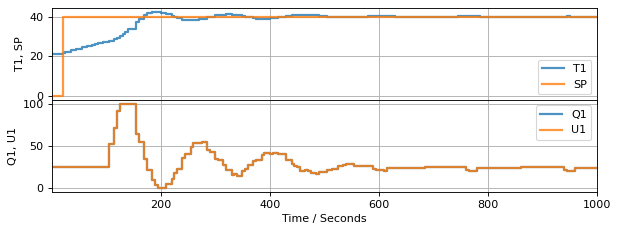

TCLab Model disconnected successfully.


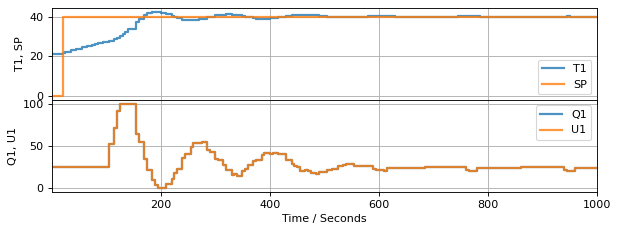

In [21]:
# add anti-integral windup feature.

def PI_bumpless(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    PV_prev = None
    while True:
        t_step, SP, PV, MV = yield MV 
        e = PV - SP
        if PV_prev is not None:
            MV += -Kp*(PV - PV_prev) - t_step*Ki*e 
            MV = max(MV_min, min(MV_max, MV))
        PV_prev = PV
        
experiment_3(PI_bumpless(10, 0.5))